In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def get_distance_matrix(pop_data,type='l1'):
    '''
    :param pop_data: n entries of row_id,col_id,grid_population
    :param type: distance type, l1, l2, ..
    :return: n * n distance matrix
    '''
    n = pop_data.shape[0]
    dist = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            if type == 'l1':
                dist[i,j] = int(abs(pop_data.x[i]-pop_data.x[j])/0.0083) + \
                            int(abs(pop_data.y[i]-pop_data.y[j])/0.00833)
            else:
                dist[i,j] = np.sqrt((int(abs(pop_data.x[i]-pop_data.x[j])/0.0083))**2 + 
                                    (int(abs(pop_data.y[i]-pop_data.y[j])/0.00833))**2)                
    dist = dist + np.transpose(dist)

    return dist

In [5]:
def cal_sat_delta_nearest(pop,i,selected_ids,dist,theta=1,lda=1,delta=10):
    tmp_dist = sorted(dist[i,selected_ids])
    sat = 0
    for _ in range(len(selected_ids)):
        if tmp_dist[_]<=delta:
            sat +=  np.exp(-tmp_dist[_] / lda) * pop[i] * (theta**(_))
    return sat

def cal_gain_delta_nearest(pop,gid,selected_ids,dist,theta=1,lda=1,delta=10):
    '''
    :param pop: a list of n grid population data
    :param gid: grid id
    :param selected_ids: selected ids
    :param dist: distance matrix
    :param theta: turning parameter
    :return:
    '''
    inc_gain = 0
    n = len(pop)
    if len(selected_ids) == 0:
        for i in range(n):
            # if gid within range delta, calculate gain
            if dist[i,gid] <= delta:
                inc_gain += np.exp(-dist[i, gid] / lda) * pop[i]
            # otherwise gain unchanged
            else:
                inc_gain += 0
    else:
        for i in range(n):
            
            # if gid with range delta :
            if dist[i,gid] <= delta:
                # find the location of gid 
                inc_gain += cal_sat_delta_nearest(pop,i,selected_ids+[gid],dist,theta,lda,delta)- \
                cal_sat_delta_nearest(pop,i,selected_ids,dist,theta,lda,delta)
            # otherwise inc = 0:
            else:
                inc_gain += 0
    return inc_gain

In [6]:
def cal_gain_nearest(pop,gid,selected_ids,dist,lda):
    '''
    :param pop: a list of n grid population data
    :param gid: grid id
    :param selected_ids: selected ids
    :param dist: distance matrix
    :param theta: turning parameter
    :return:
    '''
    inc_gain = 0
    n = len(pop)
    if len(selected_ids) == 0:
        for i in range(n):
            inc_gain += np.exp(-dist[i, gid] / lda) * pop[i]
    else:
        for i in range(n):
            tmp_dist = min(dist[i,selected_ids])
            if dist[i,gid] < tmp_dist:
                inc_gain += (np.exp(-dist[i,gid]/lda) - np.exp(-tmp_dist/lda)) * pop[i]
    return inc_gain

In [7]:
def greedy_selection(k,dist,pop,theta=1,lda=1,delta = 10):
    '''
    :param k: number of sensors available
    :param dist: distance matrix
    :param pop: population data
    :param theta: tuning parameter
    :return:
    selected ids
    '''
    selected_ids = []
    n = len(pop)
    for i in range(k):
        tmp_gain = 0
        tmp_id = 0
        for gid in range(n):
            if gid not in selected_ids:
                inc_gain = cal_gain_delta_nearest(pop,gid,selected_ids,dist,theta,lda,delta)
                if inc_gain >tmp_gain:
                    tmp_gain = inc_gain
                    tmp_id = gid
        selected_ids.append(tmp_id)
    return selected_ids

In [8]:
# benchmark 1: random selection
import random
def random_selection(k,pop):
    n = len(pop)
    selected_ids = random.sample(range(n), k)
    return selected_ids

# benchmark 2: top-k pop selection
def top_k_selection(k,pop):
    return sorted(range(len(pop)), key=lambda i: pop[i])[-k:]

In [9]:
# load data and calculate distance matrix
pop_data = pd.read_csv("sz_pop.csv")
dist = get_distance_matrix(pop_data)

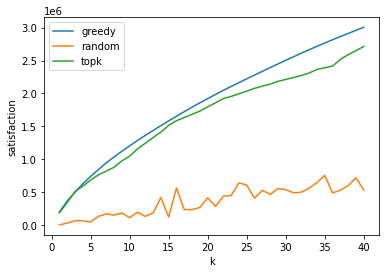

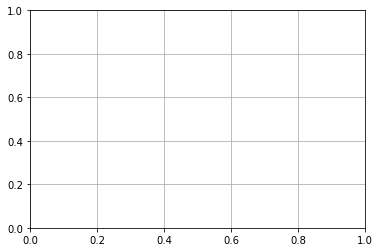

In [16]:
# generate the greedy selection results
ks = range(1,41)
sat1 = []
sat2 = []
sat3 = []
theta = 0.2
lda = 1
delta = 10

selected_ids = greedy_selection(40,dist,pop_data['pop'],theta=0.2,lda=1,delta=10)

In [28]:
print(selected_ids)

[2161, 2232, 2164, 2291, 2206, 2418, 1942, 2275, 2104, 2210, 2289, 209, 2250, 497, 2186, 1970, 126, 2109, 2207, 653, 570, 2316, 99, 1470, 1662, 2189, 1945, 266, 2107, 253, 630, 2244, 1941, 2159, 658, 2208, 2417, 473, 60, 2326]


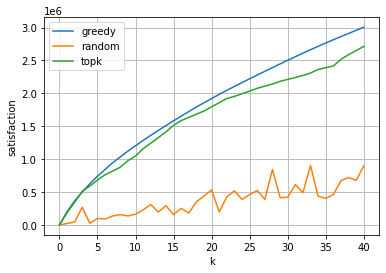

In [22]:
# generate a plot of k VS reward
sat1 = []
sat2 = []
sat3 = []

for k in ks:
    sat_1 = 0
    selected_1 = selected_ids[:k]
    for i in range(len(pop_data['pop'])):
        sat_1 += cal_sat_delta_nearest(pop_data['pop'],i,selected_1,dist,theta,lda,delta)
    sat1.append(sat_1)

    selected_2 = random_selection(k,pop_data['pop'])
    sat_2 = 0
    for i in range(len(pop_data['pop'])):
        sat_2 += cal_sat_delta_nearest(pop_data['pop'],i,selected_2,dist,theta,lda,delta)
    sat2.append(sat_2)

    selected_3 = top_k_selection(k,pop_data['pop'])
    sat_3 = 0
    for i in range(len(pop_data['pop'])):
        sat_3 += cal_sat_delta_nearest(pop_data['pop'],i,selected_3,dist,theta,lda,delta)
    sat3.append(sat_3)

plt.plot([0]+list(ks), [0]+sat1, label = "greedy")
plt.plot([0]+list(ks), [0]+sat2, label = "random")
plt.plot([0]+list(ks), [0]+sat3, label = "topk")
plt.legend()
plt.xlabel('k')
plt.ylabel('satisfaction')
#plt.savefig('benchmark.pdf')
plt.grid(True)
plt.savefig('benchmark_grid.pdf')
#plt.show()


In [14]:
sat1[39]/sat2[39]

3.729718009407557

In [15]:
sat1[39]/sat3[39]

1.1072243988503012